<a href="https://colab.research.google.com/github/joefinlon/Finlon_et_al_2021_DFR/blob/main/Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial Notebook

This notebook joins PSDs from the 2D-S and HVPS from a flight leg and plots some bulk microphysical properties and forward-modelled reflectivity values. A few sample datasets are provided in this repo. The UIOOPS package (doi: 10.5281/zenodo.3976291) is needed to process data for entire flights.

1.   Install the repository.



In [1]:
!git clone https://github.com/joefinlon/Finlon_et_al_2021_DFR.git

Cloning into 'Finlon_et_al_2021_DFR'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 28 (delta 9), reused 20 (delta 6), pack-reused 0
Unpacking objects: 100% (28/28), done.


We will exclusively use the ```p3``` module in the repo for this example. The module is more powerful if you use radar data that's been matched to the location where PSD data exist (see ```match```), but for now we'll ingore the radar inputs.

2. Import a few packages needed to join the 2D-S and HVPS PSDs.

In [2]:
import os
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

3. Load the sample matched HWIRAP dataset to use for later.

In [3]:
# change dir 
os.chdir('/content/Finlon_et_al_2021_DFR/')

match_fname = './hiwrap.matched.20200207_example.nc'
ds_matched = xr.open_dataset(match_fname)
ds_matched

<xarray.Dataset>
Dimensions:  (time: 204)
Coordinates:
  * time     (time) datetime64[ns] 2020-02-07T15:56:00 ... 2020-02-07T16:12:55
Data variables:
    z_ku     (time) float64 ...
    z_ka     (time) float64 ...
Attributes:
    Experiment:    IMPACTS
    Date:          20200207
    Data Contact:  Joe Finlon (jfinlon@uw.edu)

Let's look at the 2D-S and HVPS PSDs individually before we combine the datasets.

4. Load the 2D-S and HVPS data and view the HVPS dataset variables.

In [4]:
twods_fname = './psd.2ds.20200207_example.nc'
hvps_fname = './psd.hvps.20200207_example.nc'

ds_2ds = xr.open_dataset(twods_fname)
ds_hvps = xr.open_dataset(hvps_fname)
ds_hvps

<xarray.Dataset>
Dimensions:                          (CIParealen: 10, CIPcorrlen: 28, Habit: 10, time: 1021)
Coordinates:
  * time                             (time) datetime64[ns] 2020-02-07T15:56:0...
Dimensions without coordinates: CIParealen, CIPcorrlen, Habit
Data variables: (12/45)
    bin_min                          (CIPcorrlen) float64 ...
    bin_max                          (CIPcorrlen) float64 ...
    bin_mid                          (CIPcorrlen) float64 ...
    bin_dD                           (CIPcorrlen) float64 ...
    conc_minR                        (time, CIPcorrlen) float64 ...
    area                             (time, CIPcorrlen, CIParealen) float64 ...
    ...                               ...
    REJ_mean_aspect_ratio_rectangle  (time, CIPcorrlen) float64 ...
    REJ_mean_aspect_ratio_ellipse    (time, CIPcorrlen) float64 ...
    REJ_mean_area_ratio              (time, CIPcorrlen) float64 ...
    REJ_mean_perimeter               (time, CIPcorrlen) float64 ...
    sum_IntArr                       (time) float64 ...
    sample_vol                       (time, CIPcorrlen) float64 ...
Attributes: (12/13)
    Software:                   UIOOPS_v3.3.6
    Creation Time:              2020/08/16 16:52:19
    Description:                Contains size distributions of particle count...
    Project:                    IMPACTS
    Data Source:                /home/disk/bob/impacts/microphysics/20200207/...
    Probe Type:                 HVPS
    ...                         ...
    Dmax Definition:            D of minimum enclosing circle
    Shattering Algorithm:       Not applied
    Optional Parameters Saved:  SDs from rejected particles, SDs w/ aspect ra...
    Data Contact:               Joseph Finlon (jfinlon@uw.edu)
    Institution:                University of Washington
    Data Version:               v2

5. Now let's visualize the PSDs from each probe.

/usr/local/lib/python3.7/dist-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


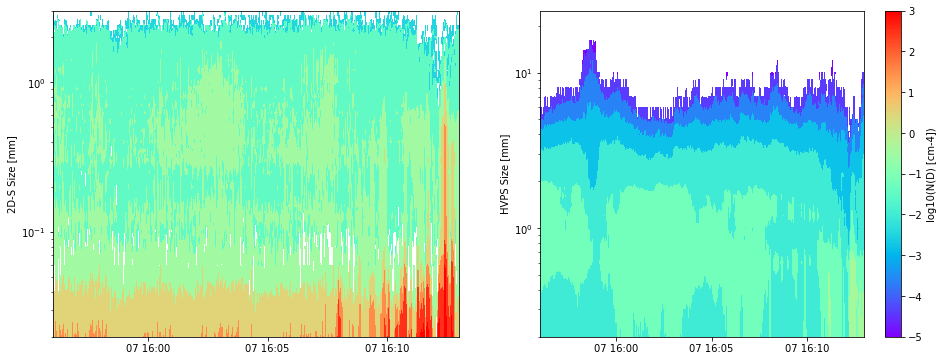

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(16, 6))
m = plt.cm.ScalarMappable(cmap='rainbow')
m.set_clim(vmin=-5, vmax=3)

ax = axs[0]
im1 = ax.contourf(
    ds_2ds.time, ds_2ds.bin_min, np.log10(ds_2ds.conc_minR.T),
    vmin=-5, vmax=3, cmap='rainbow'
    )
ax.set_yscale('log'), ax.set_ylabel('2D-S Size [mm]')
# fig.colorbar(im1, ax=ax, ticks=[-5, -4, -3, -2, -1, 0, 1, 2, 3], label='log10(N(D) [cm-4])')

ax = axs[1]
im2 = ax.contourf(
    ds_hvps.time, ds_hvps.bin_min, np.log10(ds_hvps.conc_minR.T),
    vmin=-5, vmax=3, cmap='rainbow'
    )
ax.set_yscale('log'), ax.set_ylabel('HVPS Size [mm]')
# cb = fig.colorbar(im2, ax=ax, ticks=[-5, -4, -3, -2, -1, 0, 1, 2, 3], label='log10(N(D) [cm-4])')
plt.colorbar(m, ticks=[-5, -4, -3, -2, -1, 0, 1, 2, 3], label='log10(N(D) [cm-4])')



plt.show()

The 2D-S and HVPS should not be exclusively used to derive bulk microphysical properties, so we'll use the ```psdread()``` routine to join the data at 1.4 mm.

We'll also add Z$_e$ from HIWRAP (Ku and Ka band) as inputs to find the degree of riming that best relates to each PSD.

5. First install ```pytmatrix``` and import the repo modules ```p3``` and ```forward```.

In [6]:
!pip install pytmatrix
import p3, forward
from forward import *

     |████████████████████████████████| 53 kB 2.6 MB/s 
  Created wheel for pytmatrix: filename=pytmatrix-0.3.2-cp37-cp37m-linux_x86_64.whl size=247579 sha256=6b78eed43eea7f8e69397f8128e12b57c2a3ada17df4f66b9ec2ba2a3574cf69
  Stored in directory: /root/.cache/pip/wheels/c9/28/e6/402027aee437c2b5048328a7dea3790c1fee6db64357eb2d65
Successfully built pytmatrix


6. Now run the ```p3``` module using the matched HIWRAP data as inputs.

In [7]:
date = '20200207'

matched_Zku = np.ma.masked_invalid(ds_matched.z_ku.values)
matched_Zka = np.ma.masked_invalid(ds_matched.z_ka.values)

psd = p3.psdread(
    twods_fname, hvps_fname, date,
    size_cutoff=1.4, minD=0.1, maxD=30.,
    qc=True, deadtime_thresh=0.7, verbose=False,
    start_time=None, end_time=None, tres=5,
    compute_bulk=True, compute_fits=False, Z_interp=True,
    matchedZ_W=None, matchedZ_Ka=matched_Zka, matchedZ_Ku=matched_Zku, matchedZ_X=None
    )

7. Let's plot some bulk microphysical properties that were just derived using the ```compute_bulk=True``` argument in the ```psdread()``` routine.

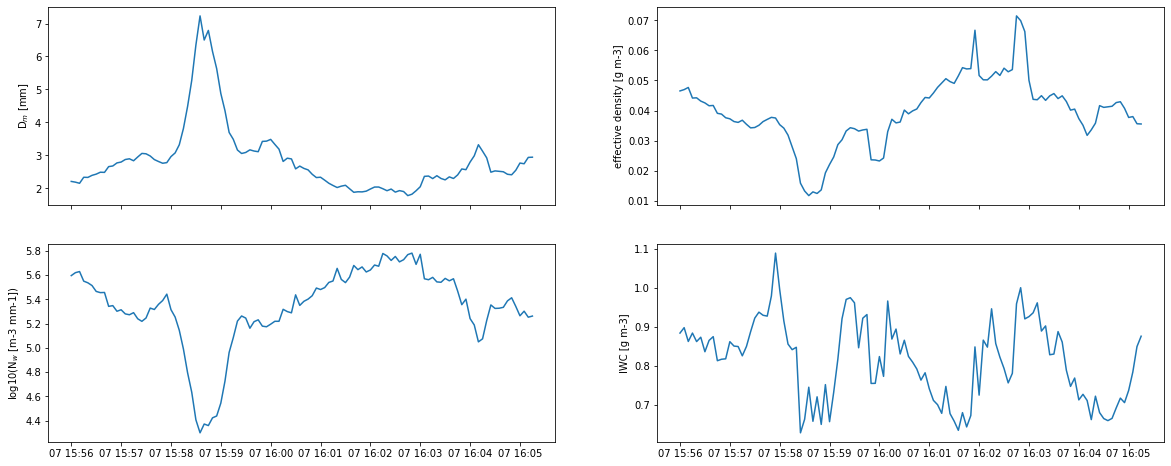

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 8), sharex=True)

ax = axs[0, 0]
ax.plot(psd['time'], psd['dm_ls'])
ax.set_ylabel('D$_m$ [mm]')

ax = axs[0, 1]
ax.plot(psd['time'], psd['eff_density_ls'])
ax.set_ylabel('effective density [g m-3]')

ax = axs[1, 0]
ax.plot(psd['time'], psd['Nw_ls'])
ax.set_ylabel('log10(N$_w$ [m-3 mm-1])')

ax = axs[1, 1]
ax.plot(psd['time'], psd['iwc_ls'])
ax.set_ylabel('IWC [g m-3]')

plt.show()

We'll finally look at how the forward-modelled Z for different degrees of riming compare to the radar observed Z.

8. Compute the forward-modelled Z<sub>Ka</sub> and Z$_{Ku}$ for different degrees of riming.

In [9]:
# Initialize the class
Z = forward_Z()

# Supply the PSD to the class (ND in m-4, D in m, dD in m)
Z.set_PSD(
    PSD=psd['ND'] * 10.**8, D=psd['bin_mid'] / 1000., dD=psd['bin_width'] / 100.
    )

# load the scattering tables
Z.load_split_L15()

# Fit the backscatter cross-sections
Z.fit_sigmas(False)

# Calculate Z
Z.calc_Z()

9. Plot the forward-modelled Z and overlay the HIWRAP values. You'll note the HIWRAP values stop ~1606 UTC as the P-3 and ER-2 were not as close in distance to bother matching the radar data.

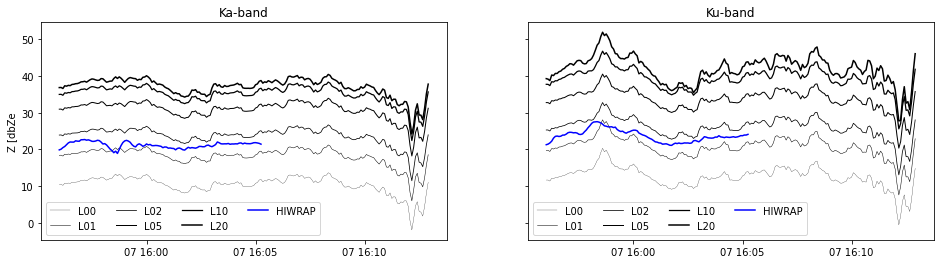

In [10]:
# Make the plot
elwp = ['L00','L01','L02','L05','L10','L20']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 4), sharex=True, sharey=True)

ax = axs[0]
ax.set_title('Ka-band')
for i, label in enumerate(elwp):
  ax.plot(psd['time'], Z.Z_ka[:, i], lw=(i+1)/4., c='k', label=label)
ax.plot(psd['time'], matched_Zka, lw=1.5, c='b', label='HIWRAP')
ax.set_ylabel('Z [dbZe')
ax.legend(ncol=4, loc='lower left')

ax = axs[1]
ax.set_title('Ku-band')
for i, label in enumerate(elwp):
  ax.plot(psd['time'], Z.Z_ku[:, i], lw=(i+1)/4., c='k', label=label)
ax.plot(psd['time'], matched_Zku, lw=1.5, c='b', label='HIWRAP')
ax.legend(ncol=4, loc='lower left')

plt.show()